# Automatic Mapping of Roads from Satellite Data using Deep Learning

# Mounting Google Drive:


1.   Import the drive module from the google.colab library.
2.   Mount Google Drive to the '/content/drive' directory in the Colab environment.
This enables easy access to files and data stored in your Google Drive within the Colab notebook.






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing necessary libraries and modules for this notebook:

## Library Installations
>
1.   **rasterio:** Install the rasterio library for geospatial data processing.
2.   **segmentation-models-pytorch:** Install the segmentation-models-pytorch library for deep learning-based image segmentation.
3.   **gdal:** Install the gdal library for geospatial data handling.


## Libraries and Functions
>
1.   **os**: For file system interaction.
2.   **osgeo (gdal, ogr)**: For geospatial data handling.
3.   **PIL (Image)**: For image processing.
4.   **torch:** For deep learning with PyTorch.
5.   **numpy (as np):** For numerical operations and array manipulation.
6.   **torchvision (transforms):** For data transformations.
7.   **matplotlib.pyplot (as plt)**: For creating plots and visualizations.
8.   **rasterio**: For geospatial data processing.



These libraries set up the necessary environment for working with geospatial data, deep learning, and visualization in the notebook.



In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 19.1 MB/s eta 0:00:00


In [3]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

In [4]:
!pip install gdal

In [5]:
import os
from osgeo import gdal, ogr
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import rasterio

# Geospatial Image Splitting


1.   Set *input_image_path* to the path of your large TIF geospatial image.
2.   Specify *output_folder* with the path where you want to save smaller square tiles.
3.   Define *size* to specify the size of each square tile.






In [6]:
# Split a large geospatial image into smaller squares, preserving geospatial data.
# The input image is divided into tiles of a specified size, and each tile is saved as a TIFF image.
# Geospatial information (e.g., coordinates and projection) is set for each output tile.

def split_image(input_image_path, output_folder, size):
    # Open the main image using GDAL
    ds = gdal.Open(input_image_path)

    if ds is None:
        print("Error: Unable to open input image.")
        return

    width = ds.RasterXSize
    height = ds.RasterYSize

    base_filename = os.path.splitext(os.path.basename(input_image_path))[0]
    counter = 1

    for i in range(0, width, size):
        for j in range(0, height, size):
            left = i
            upper = j
            right = min(i + size, width)
            lower = min(j + size, height)

            # Read all three bands (RGB) from the data
            red_band = ds.GetRasterBand(1).ReadAsArray(left, upper, right - left, lower - upper)
            green_band = ds.GetRasterBand(2).ReadAsArray(left, upper, right - left, lower - upper)
            blue_band = ds.GetRasterBand(3).ReadAsArray(left, upper, right - left, lower - upper)

            # Create a PIL Image from the three bands
            image = Image.merge("RGB", (Image.fromarray(red_band), Image.fromarray(green_band), Image.fromarray(blue_band)))

            output_image_path = os.path.join(output_folder, f"{counter}.tif")
            image.save(output_image_path, "TIFF")

            # Set geospatial information for the output tile
            x_origin = ds.GetGeoTransform()[0] + left * ds.GetGeoTransform()[1]
            y_origin = ds.GetGeoTransform()[3] + upper * ds.GetGeoTransform()[5]

            output_ds = gdal.GetDriverByName('GTiff').Create(output_image_path, size, size, 3, gdal.GDT_Byte)
            output_ds.SetGeoTransform((x_origin, ds.GetGeoTransform()[1], 0, y_origin, 0, ds.GetGeoTransform()[5]))
            output_ds.SetProjection(ds.GetProjection())

            # Write the three color bands to the output dataset
            for band_num, band_data in enumerate([red_band, green_band, blue_band], start=1):
                output_band = output_ds.GetRasterBand(band_num)
                output_band.WriteArray(band_data)

            output_ds.FlushCache()
            output_ds = None  # Close the output dataset

            counter += 1

    ds = None  # Close the input dataset

if __name__ == "__main__":
    input_image_path = "/content/drive/MyDrive/1_modified.tif"  # path to your large TIF image in Colab
    output_folder = "/content/drive/MyDrive/smaller_tiles"  #  path to the folder where you want to save the smaller squares
    size = 1024  # Size of each square

    os.makedirs(output_folder, exist_ok=True)
    split_image(input_image_path, output_folder, size)


This is UNION of all the smaller squares, preserving geospatial data.

1.jpg

# Georeferenced Image Generation from Model Predictions
1. **Load the Best Saved Model:**
The code begins by loading the best saved model checkpoint from a specified path *(model_path)*. The model is loaded to the available GPU (if available) or CPU.

2. **Define Preprocessing and Normalization:**
Preprocessing steps are defined using the *transforms.Compose function*. In this case, the image is resized to 1024x1024 pixels (if needed) and converted to a tensor.
Normalization is applied to the image based on mean and standard deviation values. These values should match the mean and std of the training data.

3. **Specify Input and Output Paths:**
The input folder containing TIFF images to be processed is specified using *folder_path*.
The output folder where georeferenced prediction images will be saved is specified using *output_folder*.

4. **Loop Through Input Images:**
The code iterates through all files in the input folder and identifies files with the ".tif" or ".tiff" extension for processing.

5. **Image Preprocessing and Prediction:**
For each input image, it follows these steps:

*   Loads and preprocesses the image as previously defined.
*   If the image has 4 channels, it removes the alpha channel (transparency).
*   Normalizes the image.
*   Converts and sends the image to the GPU (if available).
*   Makes predictions using the loaded model.

6. **Visualization:** Visualizes the predicted mask as a grayscale image using matplotlib. This step is for visual inspection.

7. **Georeferencing Information Extraction:**
Extracts georeferencing information (e.g., transformation and coordinate reference system) from the original TIFF image corresponding to the prediction.

8. **Saving Georeferenced Prediction:**
Creates an output file path for the georeferenced prediction image.
Writes the prediction image in GeoTIFF format using rasterio. The georeferencing information is applied to the output image.

9. **Output Display and Information:**
Displays the saved georeferenced prediction file path.

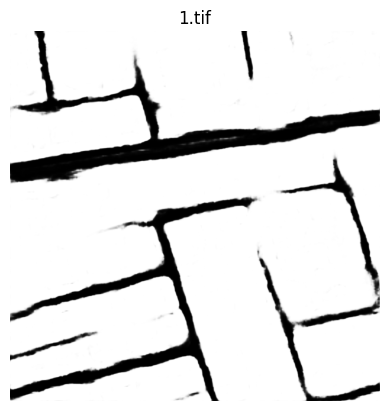

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


Saved georeferenced prediction: /content/drive/MyDrive/output/1_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/2_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/3_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/4_georeferenced.tif


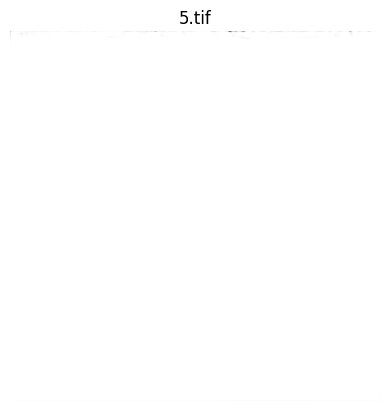

Saved georeferenced prediction: /content/drive/MyDrive/output/5_georeferenced.tif


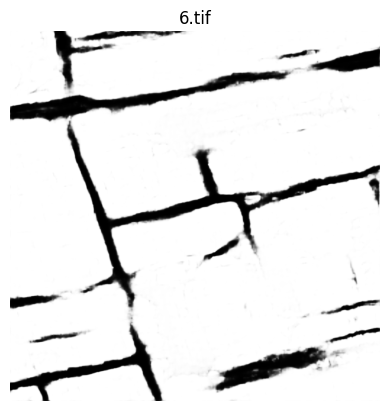

Saved georeferenced prediction: /content/drive/MyDrive/output/6_georeferenced.tif


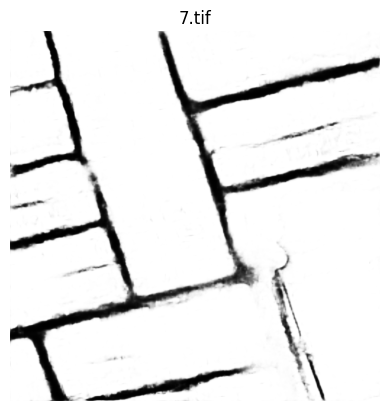

Saved georeferenced prediction: /content/drive/MyDrive/output/7_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/8_georeferenced.tif


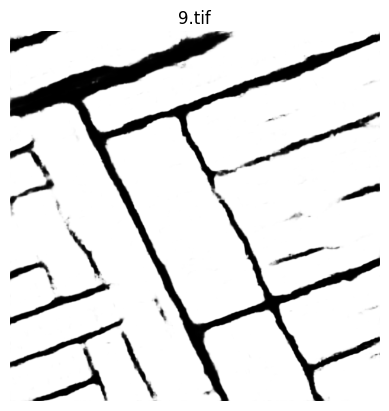

Saved georeferenced prediction: /content/drive/MyDrive/output/9_georeferenced.tif


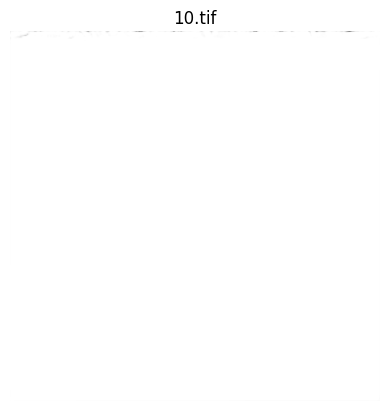

Saved georeferenced prediction: /content/drive/MyDrive/output/10_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/11_georeferenced.tif


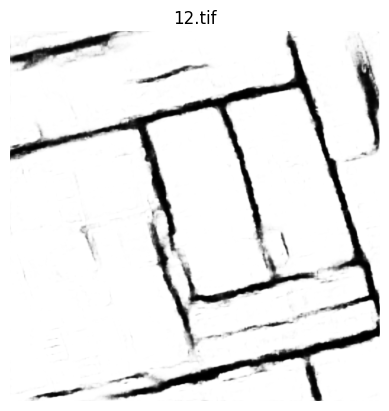

Saved georeferenced prediction: /content/drive/MyDrive/output/12_georeferenced.tif


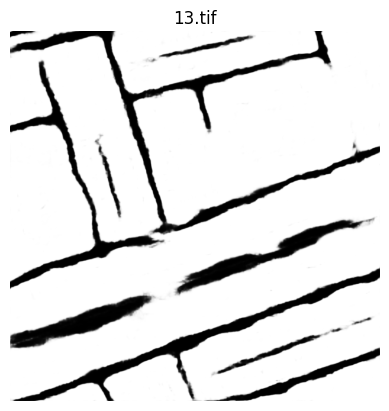

Saved georeferenced prediction: /content/drive/MyDrive/output/13_georeferenced.tif


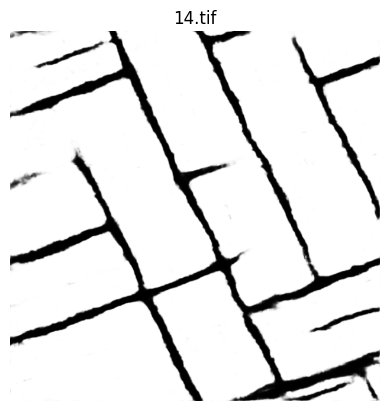

Saved georeferenced prediction: /content/drive/MyDrive/output/14_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/15_georeferenced.tif


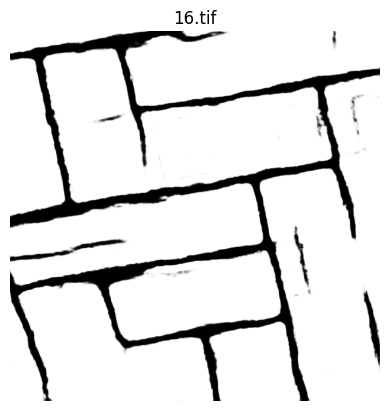

Saved georeferenced prediction: /content/drive/MyDrive/output/16_georeferenced.tif


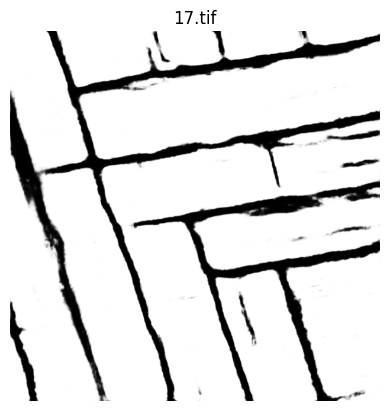

Saved georeferenced prediction: /content/drive/MyDrive/output/17_georeferenced.tif


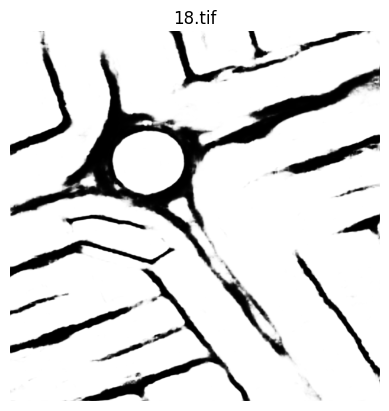

Saved georeferenced prediction: /content/drive/MyDrive/output/18_georeferenced.tif


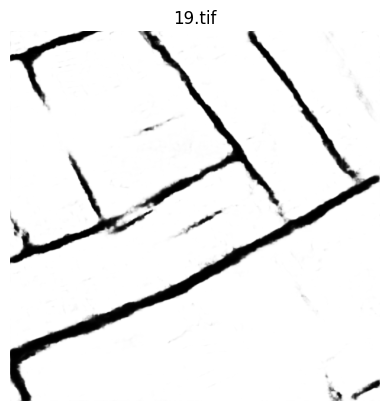

Saved georeferenced prediction: /content/drive/MyDrive/output/19_georeferenced.tif


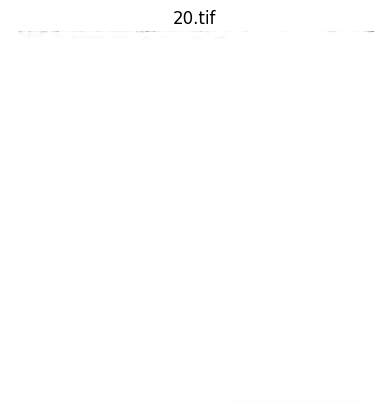

Saved georeferenced prediction: /content/drive/MyDrive/output/20_georeferenced.tif


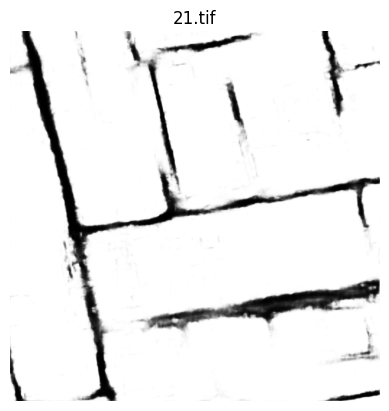

Saved georeferenced prediction: /content/drive/MyDrive/output/21_georeferenced.tif


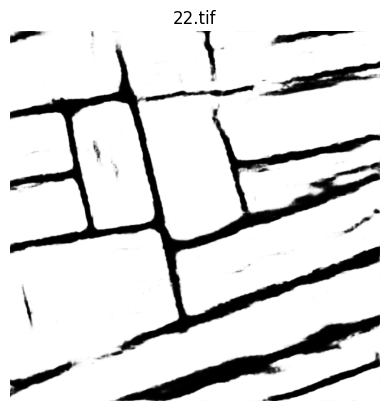

Saved georeferenced prediction: /content/drive/MyDrive/output/22_georeferenced.tif


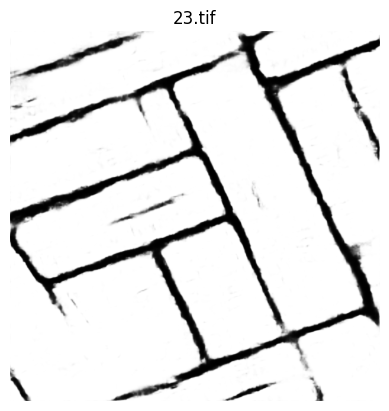

Saved georeferenced prediction: /content/drive/MyDrive/output/23_georeferenced.tif


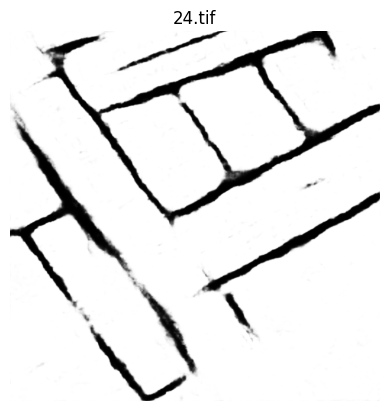

Saved georeferenced prediction: /content/drive/MyDrive/output/24_georeferenced.tif


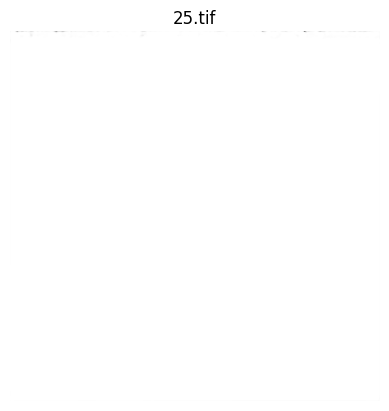

Saved georeferenced prediction: /content/drive/MyDrive/output/25_georeferenced.tif


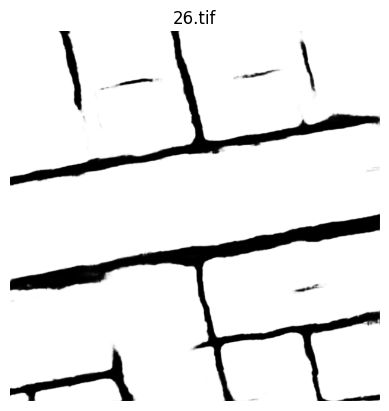

Saved georeferenced prediction: /content/drive/MyDrive/output/26_georeferenced.tif


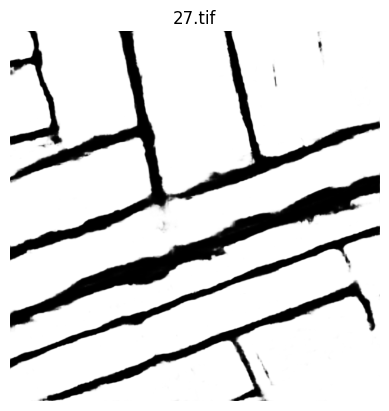

Saved georeferenced prediction: /content/drive/MyDrive/output/27_georeferenced.tif


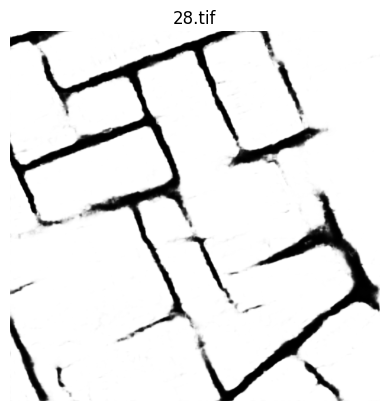

Saved georeferenced prediction: /content/drive/MyDrive/output/28_georeferenced.tif


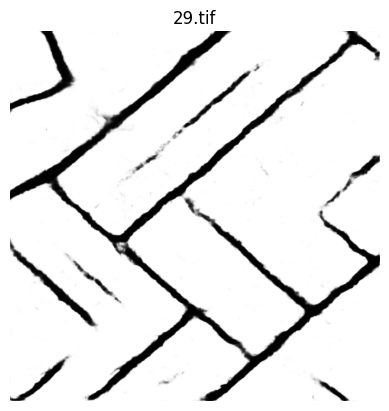

Saved georeferenced prediction: /content/drive/MyDrive/output/29_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/30_georeferenced.tif


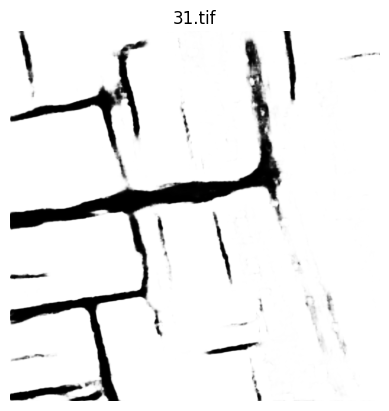

Saved georeferenced prediction: /content/drive/MyDrive/output/31_georeferenced.tif


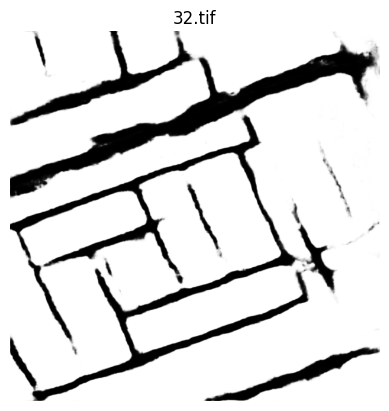

Saved georeferenced prediction: /content/drive/MyDrive/output/32_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/33_georeferenced.tif


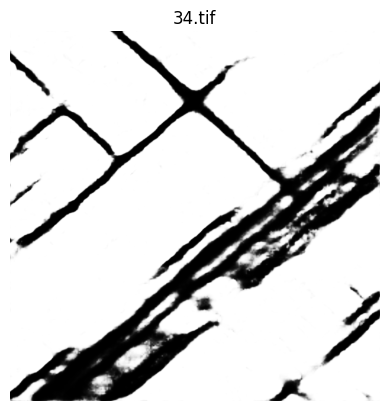

Saved georeferenced prediction: /content/drive/MyDrive/output/34_georeferenced.tif


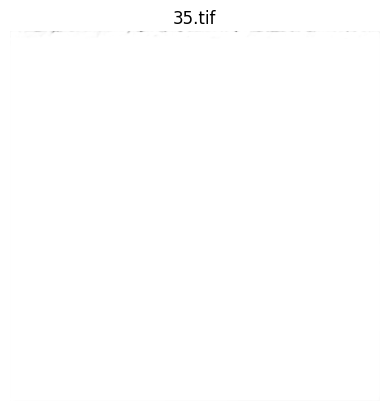

Saved georeferenced prediction: /content/drive/MyDrive/output/35_georeferenced.tif


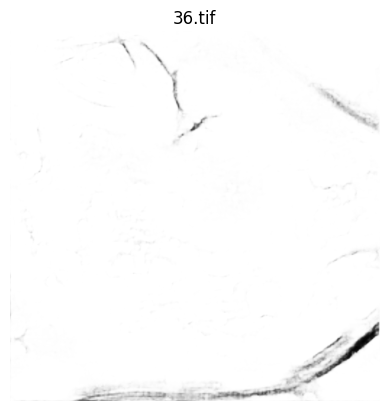

Saved georeferenced prediction: /content/drive/MyDrive/output/36_georeferenced.tif


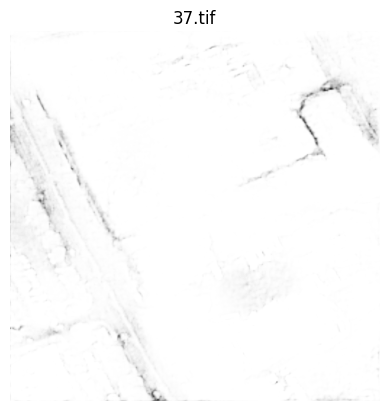

Saved georeferenced prediction: /content/drive/MyDrive/output/37_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/38_georeferenced.tif


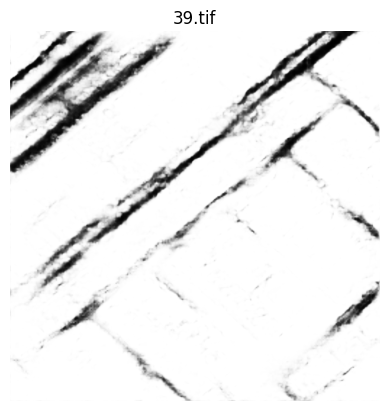

Saved georeferenced prediction: /content/drive/MyDrive/output/39_georeferenced.tif


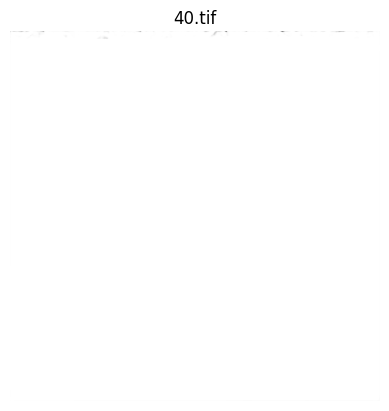

Saved georeferenced prediction: /content/drive/MyDrive/output/40_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/41_georeferenced.tif


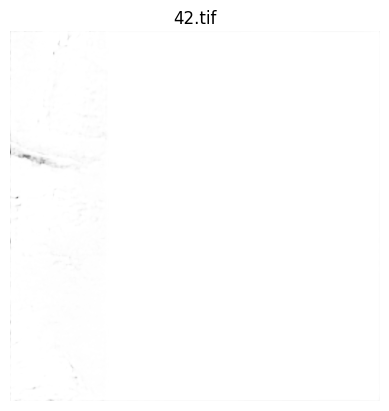

Saved georeferenced prediction: /content/drive/MyDrive/output/42_georeferenced.tif


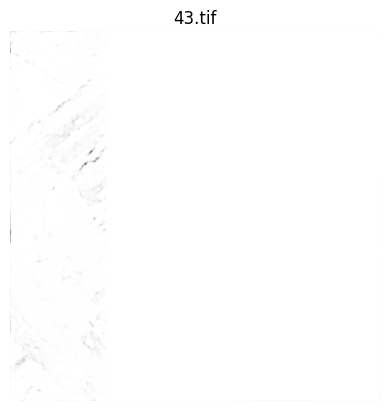

Saved georeferenced prediction: /content/drive/MyDrive/output/43_georeferenced.tif


Saved georeferenced prediction: /content/drive/MyDrive/output/44_georeferenced.tif


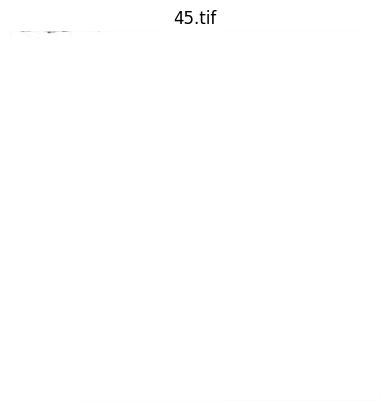

Saved georeferenced prediction: /content/drive/MyDrive/output/45_georeferenced.tif


In [7]:
#To generate and save georeferenced images based on predictions obtained from a trained model.
#It processes input images, performs predictions, and saves the results in GeoTIFF format with georeferencing information.
#normal output which is georefrenced

# Load the best saved model checkpoint
model_path = '/content/drive/MyDrive/best_model.pth'  # path to model
best_model = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Define preprocessing and normalization
preprocessing = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Resize to 1024x1024 (if needed)
    transforms.ToTensor(),
])
# Normalize the image if needed (match the mean and std to your training data)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the folder containing your TIFF images
folder_path = '/content/drive/MyDrive/smaller_tiles'  # path to your image folder

# Output folder where you want to save the prediction images
output_folder = '/content/drive/MyDrive/output'  #path to your desired output folder

# Make sure the output folder exists; if not, create it
os.makedirs(output_folder, exist_ok=True)

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        # Load and preprocess the image as you did before
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        image = preprocessing(image)

        if image.shape[0] == 4:
            image = image[:3]

        image = transforms.functional.normalize(image, mean, std)
        image = image.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

        # Predict the image
        with torch.no_grad():
            pred_mask = best_model(image)

        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        pred_mask = np.transpose(pred_mask, (1, 2, 0))

        # Convert pred_mask to grayscale
        pred_mask_gray = np.mean(pred_mask, axis=2)  # Convert to grayscale by taking the mean of color channels

        # Extract georeferencing information from the original TIFF image corresponding to this prediction
        original_image_path = os.path.join(folder_path, filename)  # Use the input image for georeferencing
        with rasterio.open(original_image_path) as src:
            geotransform = src.transform
            crs = src.crs

        # visualize the predictioned
        single_channel_mask = pred_mask[:, :, 0]
        # Visualize the predicted image
        plt.figure()
        plt.imshow(single_channel_mask, cmap='gray')
        plt.axis('off')
        plt.title(filename)

        # Show the plot
        plt.show()

        # Create the output file path for the georeferenced prediction image
        output_path = os.path.join(output_folder, filename.replace('.tif', '_georeferenced.tif'))

        # Write the prediction image with georeferencing information
        with rasterio.open(output_path, 'w', driver='GTiff', height=pred_mask_gray.shape[0], width=pred_mask_gray.shape[1], count=1, dtype=pred_mask_gray.dtype, crs=crs) as dst:
            dst.write(pred_mask_gray, 1)
            dst.transform = geotransform  # Apply the geotransform

        print(f'Saved georeferenced prediction: {output_path}')


This is UNION of georeferenced predictions

2.jpg

# TIFF to Shapefile Conversion



1.   **Folder Specification:**

*   *input_folder*: The directory containing the TIFF files to be converted.
*   *output_folder*: The location where the resulting shapefiles will be stored.

2.   **Conversion Function (convert_tiff_to_shapefile):**


*   Extracts the input TIFF's base name (without the extension).
*   Constructs the output shapefile path.
*   Opens the input raster with GDAL.
*   Creates a new ESRI shapefile in the output folder.
*   Adds a field for raster values.
*   Uses GDAL's *Polygonize* function for raster-to-polygon conversion.
*   Closes both input and output datasets.

3. **Iterate Through TIFF Files:**


*   The code iterates through all files in the input folder.
*   For each file with a ".tif" extension, it constructs the complete path to the TIFF file.

*   The *convert_tiff_to_shapefile* function is invoked to convert each TIFF file into a corresponding shapefile.










In [8]:
# Define the input and output folders
input_folder = "/content/drive/MyDrive/output"
output_folder = "/content/drive/MyDrive/shapefiles"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to convert a TIFF file to a shapefile
def convert_tiff_to_shapefile(input_tiff, output_folder):
    # Extract the file name (without extension) from the input TIFF file
    base_name = os.path.splitext(os.path.basename(input_tiff))[0]

    # Set the output shapefile path
    output_shapefile = os.path.join(output_folder, f"{base_name}.shp")

    # Open the input raster dataset
    src_ds = gdal.Open(input_tiff)

    # Create a new shapefile
    drv = ogr.GetDriverByName("ESRI Shapefile")
    dst_ds = drv.CreateDataSource(output_shapefile)
    dst_layer = dst_ds.CreateLayer("output", geom_type=ogr.wkbPolygon)

    # Create a field in the shapefile for the raster values
    field_defn = ogr.FieldDefn("DN", ogr.OFTInteger)
    dst_layer.CreateField(field_defn)

    # Use the gdal.Polygonize function to create polygons from the raster
    gdal.Polygonize(src_ds.GetRasterBand(1), None, dst_layer, 0, [], callback=None)

    # Close the datasets
    src_ds = None
    dst_ds = None

# Iterate through all TIFF files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        # Construct the full path to the TIFF file
        tiff_file_path = os.path.join(input_folder, filename)

        # Call the function to convert the TIFF file to a shapefile
        convert_tiff_to_shapefile(tiff_file_path, output_folder)


This is UNION of Shapefiles generated

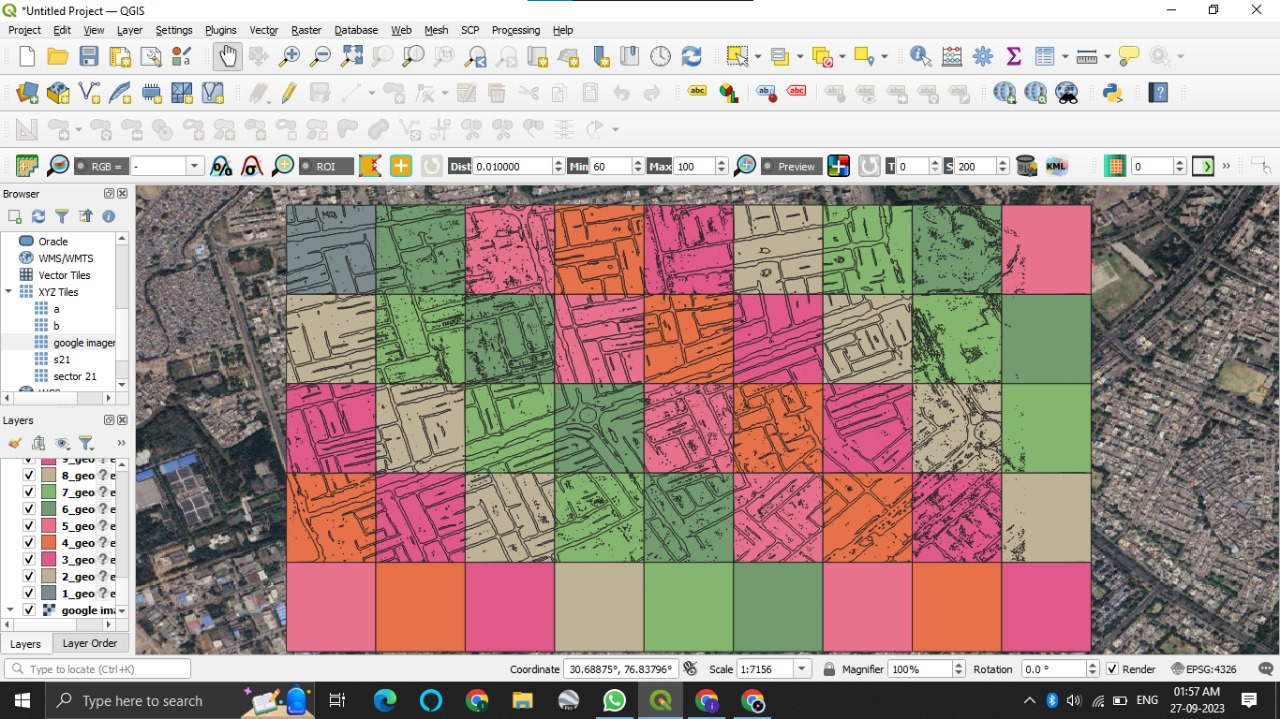